In [7]:
from __future__ import print_function
from utils import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
import os
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, classification_report, accuracy_score, plot_confusion_matrix, roc_curve, auc
import pickle
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
#user defined variables
PATCH_SIZE  = 64
BATCH_SIZE  = 32
DATASET_DIR = 'MIT_split'
PATCHES_DIR = 'MIT_split_patches'
MODEL_FNAME = 'patch_based_mlp_64.h5'

def build_mlp(input_size=PATCH_SIZE,phase='TRAIN'):
    model = Sequential()
    model.add(Reshape((input_size*input_size*3,),input_shape=(input_size, input_size, 3)))
    model.add(Dense(units=2048, activation='relu',name='second'))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.2))
    model.add(Dense(units=1024, activation='relu', name='third'))
    #model.add(Dropout(0.2))
    model.add(Dense(units=512, activation='relu', name='fourth'))
    if phase=='TEST':
        model.add(Dense(units=8, activation='linear')) # In test phase we softmax the average output over the image patches
    else:
        model.add(Dense(units=8, activation='softmax'))
    return model

if not os.path.exists(DATASET_DIR):
    colorprint(Color.RED, 'ERROR: dataset directory '+DATASET_DIR+' do not exists!\n')
    quit()
    
if not os.path.exists(PATCHES_DIR):
    colorprint(Color.YELLOW, 'WARNING: patches dataset directory '+PATCHES_DIR+' do not exists!\n')
    colorprint(Color.BLUE, 'Creating image patches dataset into '+PATCHES_DIR+'\n')
    generate_image_patches_db(DATASET_DIR,PATCHES_DIR,patch_size=PATCH_SIZE)
    colorprint(Color.BLUE, 'Done!\n')

In [ ]:
colorprint(Color.BLUE, 'Building MLP model...\n')
model = build_mlp(input_size=PATCH_SIZE)

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

print(model.summary())

colorprint(Color.BLUE, 'Done!\n')

if not os.path.exists(MODEL_FNAME):
    colorprint(Color.YELLOW, 'WARNING: model file '+MODEL_FNAME+' do not exists!\n')
    colorprint(Color.BLUE, 'Start training...\n')
    # this is the dataset configuration we will use for training
    # only rescaling
    train_datagen = ImageDataGenerator(
          rescale=1./255,
          horizontal_flip=True)

    # this is the dataset configuration we will use for testing:
    # only rescaling
    test_datagen = ImageDataGenerator(rescale=1./255)

    # this is a generator that will read pictures found in
    # subfolers of 'data/train', and indefinitely generate
    # batches of augmented image data
    train_generator = train_datagen.flow_from_directory(
          PATCHES_DIR+'/train',  # this is the target directory
          target_size=(PATCH_SIZE, PATCH_SIZE),  # all images will be resized to PATCH_SIZExPATCH_SIZE
          batch_size=BATCH_SIZE,
          classes = ['coast','forest','highway','inside_city','mountain','Opencountry','street','tallbuilding'],
          class_mode='categorical')  # since we use binary_crossentropy loss, we need categorical labels

    # this is a similar generator, for validation data
    validation_generator = test_datagen.flow_from_directory(
          PATCHES_DIR+'/test',
          target_size=(PATCH_SIZE, PATCH_SIZE),
          batch_size=BATCH_SIZE,
          classes = ['coast','forest','highway','inside_city','mountain','Opencountry','street','tallbuilding'],
          class_mode='categorical')

    model.fit_generator(
          train_generator,
          steps_per_epoch=18810 // BATCH_SIZE,
          epochs=75,
          validation_data=validation_generator,
          validation_steps=8070 // BATCH_SIZE)

    colorprint(Color.BLUE, 'Done!\n')
    colorprint(Color.BLUE, 'Saving the model into '+MODEL_FNAME+' \n')
    model.save_weights(MODEL_FNAME)  # always save your weights after training or during training
    colorprint(Color.BLUE, 'Done!\n')

In [8]:
model = build_mlp(input_size=PATCH_SIZE, phase='TEST')

Patch size=64 -> Test_acc=%74 <br>
Patch size=32 -> Test_acc=%73 <br>
Patch size=16 -> Test_acc=%60 <br>
Patch size=8 -> Test_acc=%56 <br>

In [ ]:
colorprint(Color.BLUE, 'Building MLP model for testing...\n')

model = build_mlp(input_size=PATCH_SIZE, phase='TEST')
print(model.summary())

colorprint(Color.BLUE, 'Done!\n')

colorprint(Color.BLUE, 'Loading weights from '+MODEL_FNAME+' ...\n')
print ('\n')

model.load_weights(MODEL_FNAME)

colorprint(Color.BLUE, 'Done!\n')

colorprint(Color.BLUE, 'Start evaluation ...\n')

directory = DATASET_DIR + '/test'
classes = {'coast':0,'forest':1,'highway':2,'inside_city':3,'mountain':4,'Opencountry':5,'street':6,'tallbuilding':7}
correct = 0.
total   = 807
count   = 0

for class_dir in os.listdir(directory):
    cls = classes[class_dir]
    for imname in os.listdir(os.path.join(directory,class_dir)):
        im = Image.open(os.path.join(directory,class_dir,imname))
        patches = image.extract_patches_2d(np.array(im), (PATCH_SIZE, PATCH_SIZE), max_patches=int(np.array(im).shape[0]/PATCH_SIZE)**2)
        out = model.predict(patches/255.)
        predicted_cls = np.argmax(softmax(np.mean(out,axis=0)) )
        if predicted_cls == cls:
            correct+=1
            count += 1
    print('Evaluated images: '+str(count)+' / '+str(total), end='\r')
    
colorprint(Color.BLUE, 'Done!\n')
colorprint(Color.GREEN, 'Test Acc. = '+str(correct/total)+'\n')

D:\Uygulamalar\Anaconda\envs\myenv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


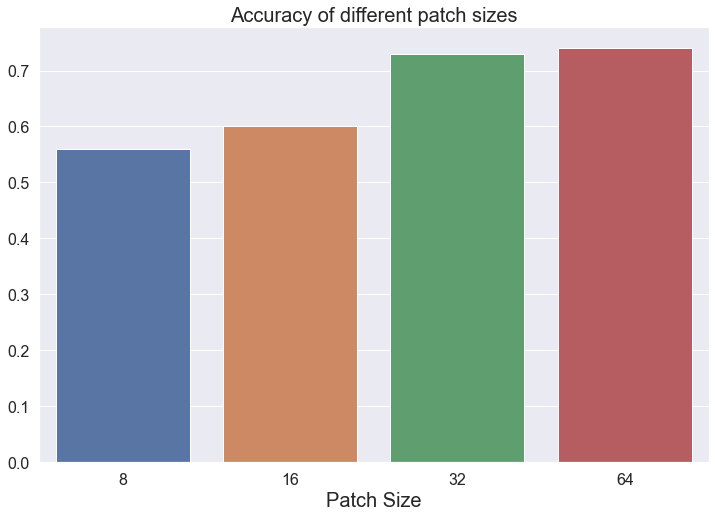

In [22]:
x = [8, 16, 32, 64]
y = [0.56, 0.6, 0.73, 0.74]

sns.barplot(x, y)
plt.xlabel("Patch Size", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Accuracy of different patch sizes", fontsize=20)
sns.set(rc={'figure.figsize':(12, 8)})

In [ ]:
layer = Model(inputs=model.input, outputs=model.get_layer('third').output)

directory = DATASET_DIR + '/train'
layer_preds_train = []
for class_dir in os.listdir(directory):
    cls = classes[class_dir]
    for imname in os.listdir(os.path.join(directory,class_dir)):
        im = Image.open(os.path.join(directory,class_dir,imname))
        patches = image.extract_patches_2d(np.array(im), (PATCH_SIZE, PATCH_SIZE), max_patches=int(np.array(im).shape[0]/PATCH_SIZE)**2)
        out = layer.predict(patches/255.)
        layer_preds_train.append(out)
        
        
directory = DATASET_DIR + '/test'    
layer_preds_test = []
for class_dir in os.listdir(directory):
    cls = classes[class_dir]
    for imname in os.listdir(os.path.join(directory,class_dir)):
        im = Image.open(os.path.join(directory,class_dir,imname))
        patches = image.extract_patches_2d(np.array(im), (PATCH_SIZE, PATCH_SIZE), max_patches=int(np.array(im).shape[0]/PATCH_SIZE)**2)
        out = layer.predict(patches/255.)
        layer_preds_test.append(out)

In [ ]:
layer_preds_test[0].shape

In [ ]:
def histogramIntersection(data_1, data_2):
    kernel = np.zeros((data_1.shape[0], data_2.shape[0]))

    for d in range(data_1.shape[1]):
        column_1 = data_1[:, d].reshape(-1, 1)
        column_2 = data_2[:, d].reshape(-1, 1)
        kernel += np.minimum(column_1, column_2.T)

    return kernel

In [ ]:
train_labels = pickle.load(open('MIT_split//train_labels.dat','rb'))
test_labels = pickle.load(open('MIT_split//test_labels.dat','rb'))

In [ ]:
k = 512

codebook = get_codebook(layer_preds_train, k)
visual_words_train = get_visual_words(codebook, layer_preds_train, k)
visual_words_test = get_visual_words(codebook, layer_preds_test, k)

In [ ]:
params = [{'kernel':('poly', 'rbf', histogramIntersection),
           "C":[0.01, 0.05, 0.1, 0.5]}]

svc = svm.SVC() 
svm_grid = GridSearchCV(svc, params, cv=8, 
                        scoring=["accuracy", "f1_macro"], refit="accuracy", return_train_score=True)

svm_grid.fit(visual_words_train, train_labels)

In [ ]:
svm_grid.best_params_

In [ ]:
svc = svm.SVC(kernel=histogramIntersection, C=0.05) 
svc.fit(visual_words_train, train_labels)
train_preds = svc.predict(visual_words_train)
test_preds = svc.predict(visual_words_test)

print("Train", accuracy_score(train_labels, train_preds))
print("Test", accuracy_score(test_labels, test_preds))

In [14]:
X = [64,128,192,256,512]
Y1 = [0.5, 0.52, 0.54, 0.54, 0.56]
Y2 = [0.54, 0.57, 0.57, 0.57, 0.58]

<Figure size 1296x432 with 0 Axes>

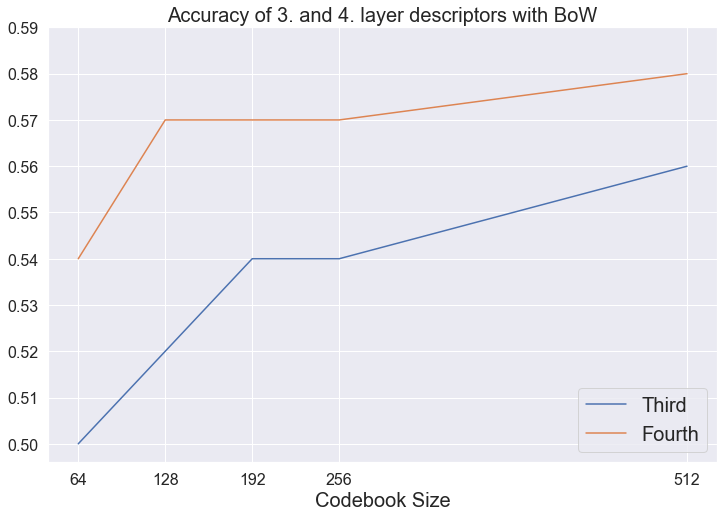

<Figure size 1296x432 with 0 Axes>

In [25]:
plt.plot(X, Y1)
plt.plot(X, Y2)

plt.title("Accuracy of 3. and 4. layer descriptors with BoW", fontsize=20)
plt.xlabel("Codebook Size", fontsize=20)
plt.xticks(ticks=[64,128,192,256,512], fontsize=16)
plt.yticks(ticks=np.arange(0.5,0.6,0.01), fontsize=16)
plt.legend(['Third', 'Fourth'], loc='lower right', fontsize=20)
plt.figure(figsize=(18,6))


In [ ]:
X = np.arange(4)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, Y1, color = 'b', width = 0.25)
ax.bar(X + 0.25, Y2, color = 'g', width = 0.25)


## Third layer

64 = %50 <br>
128 = %52 <br>
192 = %54 <br>
256 = %54 <br>
512 = %56

## Fourth layer

 64 = %54 <br>
128 = %57 <br>
192 = %57 <br>
256 = %57 <br>
512 = %58